![head.png](https://github.com/cafawo/FinancialDataAnalytics/blob/master/figures/head.jpg?raw=1)

# Financial Data Analytics in Python

**Prof. Dr. Fabian Woebbeking**</br>
Assistant Professor of Financial Economics

IWH - Leibniz Institute for Economic Research</br>
MLU - Martin Luther University Halle-Wittenberg

fabian.woebbeking@iwh-halle.de

# Homework: data management

You will need a Git/GitHub repository to submit your course deliverables. Consult [**slides.ipynb**](https://github.com/cafawo/FinancialDataAnalytics) for help with the tasks below! If you need further assistance, do not hesitate to open a Q&A at https://github.com/cafawo/FinancialDataAnalytics/discussions

### Task: 

Use Deribit's `"/public/get_tradingview_chart_data"` API endpoint to download historical price data for **"BTC-PERPETUAL"** with a resolution of $60$ minutes, reaching as far back as possible.

Hint: https://docs.deribit.com/#public-get_tradingview_chart_data

In [62]:
import time
import requests

url = 'https://test.deribit.com/api/v2/'

msg = {
        "jsonrpc" : "2.0",
        "id" : 833,
        "method" : "public/get_tradingview_chart_data",
        "params" : {
        "instrument_name" : "BTC-PERPETUAL",
        "end_timestamp": int(time.time() * 1000),  # In Epoch milliseconds
        "start_timestamp": int((time.time() - 1e6) * 1000), # In Epoch milliseconds
        "resolution" : "60"  # Minute data
        }
    }
response = requests.post(url, json=msg)
response = response.json()

### Task: 

Create a Pandas data frame called "ohlc" with the price data from above. Add the following columns:
```Python
ohlc['timestamp'] = pd.to_datetime(ohlc['ticks'], unit='ms')
ohlc['instrument_name'] = "BTC-PERPETUAL"
ohlc['resolution'] = 60
```

Save `ohlc` into a table of the same name inside a database called "07_datam.db".


In [63]:
import pandas as pd
from sqlalchemy import create_engine

ohlc = pd.DataFrame(response['result'])
ohlc['timestamp'] = pd.to_datetime(ohlc['ticks'], unit='ms')
ohlc['instrument_name'] = "BTC-PERPETUAL"
ohlc['resolution'] = 60
# Stuff we don't need
ohlc.drop(columns=['ticks', 'status'], inplace=True)
# Display values
display(ohlc)

# Connect to the database
engine = create_engine('sqlite:///07_datam.db')
# Write data to the database
ohlc.to_sql("ohlc", engine, if_exists="replace", index=False)

,volume,open,low,high,cost,close,timestamp,instrument_name,resolution
0,947.870149,26874.0,26445.0,27331.0,25456370.0,26888.0,2023-05-19 05:00:00,BTC-PERPETUAL,60
1,532.641060,26887.5,26517.0,26943.0,14208270.0,26914.5,2023-05-19 06:00:00,BTC-PERPETUAL,60
2,621.645335,26914.5,26857.0,26962.5,16718970.0,26872.0,2023-05-19 07:00:00,BTC-PERPETUAL,60
3,1153.381027,26869.5,26858.0,26943.0,31042320.0,26904.0,2023-05-19 08:00:00,BTC-PERPETUAL,60
4,356.907462,26904.5,26832.0,26914.5,9586520.0,26846.5,2023-05-19 09:00:00,BTC-PERPETUAL,60
...,...,...,...,...,...,...,...,...,...
274,1804.152669,27645.0,27636.5,27754.5,49976740.0,27697.5,2023-05-30 15:00:00,BTC-PERPETUAL,60
275,3068.215945,27697.5,27420.0,27761.5,84906520.0,27734.5,2023-05-30 16:00:00,BTC-PERPETUAL,60
276,1490.165749,27734.5,27647.0,27798.5,41305910.0,27713.0,2023-05-30 17:00:00,BTC-PERPETUAL,60
277,1588.089118,27718.5,27684.5,27826.0,44083320.0,27792.5,2023-05-30 18:00:00,BTC-PERPETUAL,60


279

### Task: 

Create a Python `class DataHandler` that connects to 07_datam.db. The class should have functions that:
* download and save,
* select and return, and
* display data as a plot (e.g. the last price over time).

In [64]:
import matplotlib.pyplot as plt

class DataHandler:
    def __init__(self, db_name):
        self.engine = create_engine(f'sqlite:///{db_name}')
        self.url = "https://www.deribit.com/api/v2/public/get_tradingview_chart_data"
        
    def download(self, instrument_name):
        msg = {
                "jsonrpc" : "2.0",
                "id" : 833,
                "method" : "public/get_tradingview_chart_data",
                "params" : {
                "instrument_name" : instrument_name,
                "end_timestamp": int(time.time() * 1000),  # In Epoch milliseconds
                "start_timestamp": int((time.time() - 1e6) * 1000), # In Epoch milliseconds
                "resolution" : "60"  # Minute data
                }
            }
        response = requests.post(url, json=msg)
        data = response.json()
        ohlc = pd.DataFrame(data['result'])
        ohlc['timestamp'] = pd.to_datetime(ohlc['ticks'], unit='ms')
        ohlc['instrument_name'] = instrument_name
        ohlc['resolution'] = 60
        # Please note the if_exists='replace' ... one might if_exists='append' but need to check for duplicates!
        ohlc.to_sql('ohlc', self.engine, if_exists='replace')
        
    def select(self, query):
        return pd.read_sql(query, self.engine)
        
    def plot(self, query):
        df = self.select(query)
        df.plot()
        plt.title(f'{query}')
        plt.show()

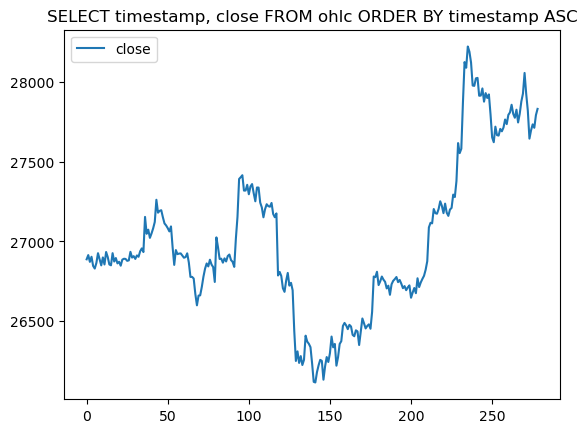

In [65]:
dh = DataHandler('07_datam.db')
dh.download('BTC-PERPETUAL')
data = dh.select('SELECT * FROM ohlc')
dh.plot('SELECT timestamp, close FROM ohlc ORDER BY timestamp ASC')